# Project PA 228 - Image Classification
### - Kuldeep Singh, 541673

The task is to classify several cropped satellite images of the Amazon using multiple pre-defined labels such as atmospheric conditions and classes of land cover. I have downloaded data from https://www.kaggle.com/datasets/nikitarom/planets-dataset

In [1]:
#uncomment code in next cell for downloading dataset

In [2]:
# import zipfile
# !git clone https://github.com/KSRAJAWAT111/planet-dataset.git
# with zipfile.ZipFile('planet-dataset/planet_.zip', 'r') as zip_ref:
#     zip_ref.extractall('')

####  Loading Dataset

In [3]:
import torch
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
dev

device(type='cuda')

In [5]:
import pandas as pd

In [6]:
classes = pd.read_csv(r"planet/train_classes.csv")

In [7]:
classes.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [8]:
classes.shape

(40479, 2)

We have multiple lables for 40479 training images.

In [9]:
#Finding how many unique tags are there
labels = set()
for i in range(len(classes)):
    tags = classes['tags'][i].split(' ')
    labels.update(tags)


In [10]:
print(len(labels))
labels

17


{'agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water'}

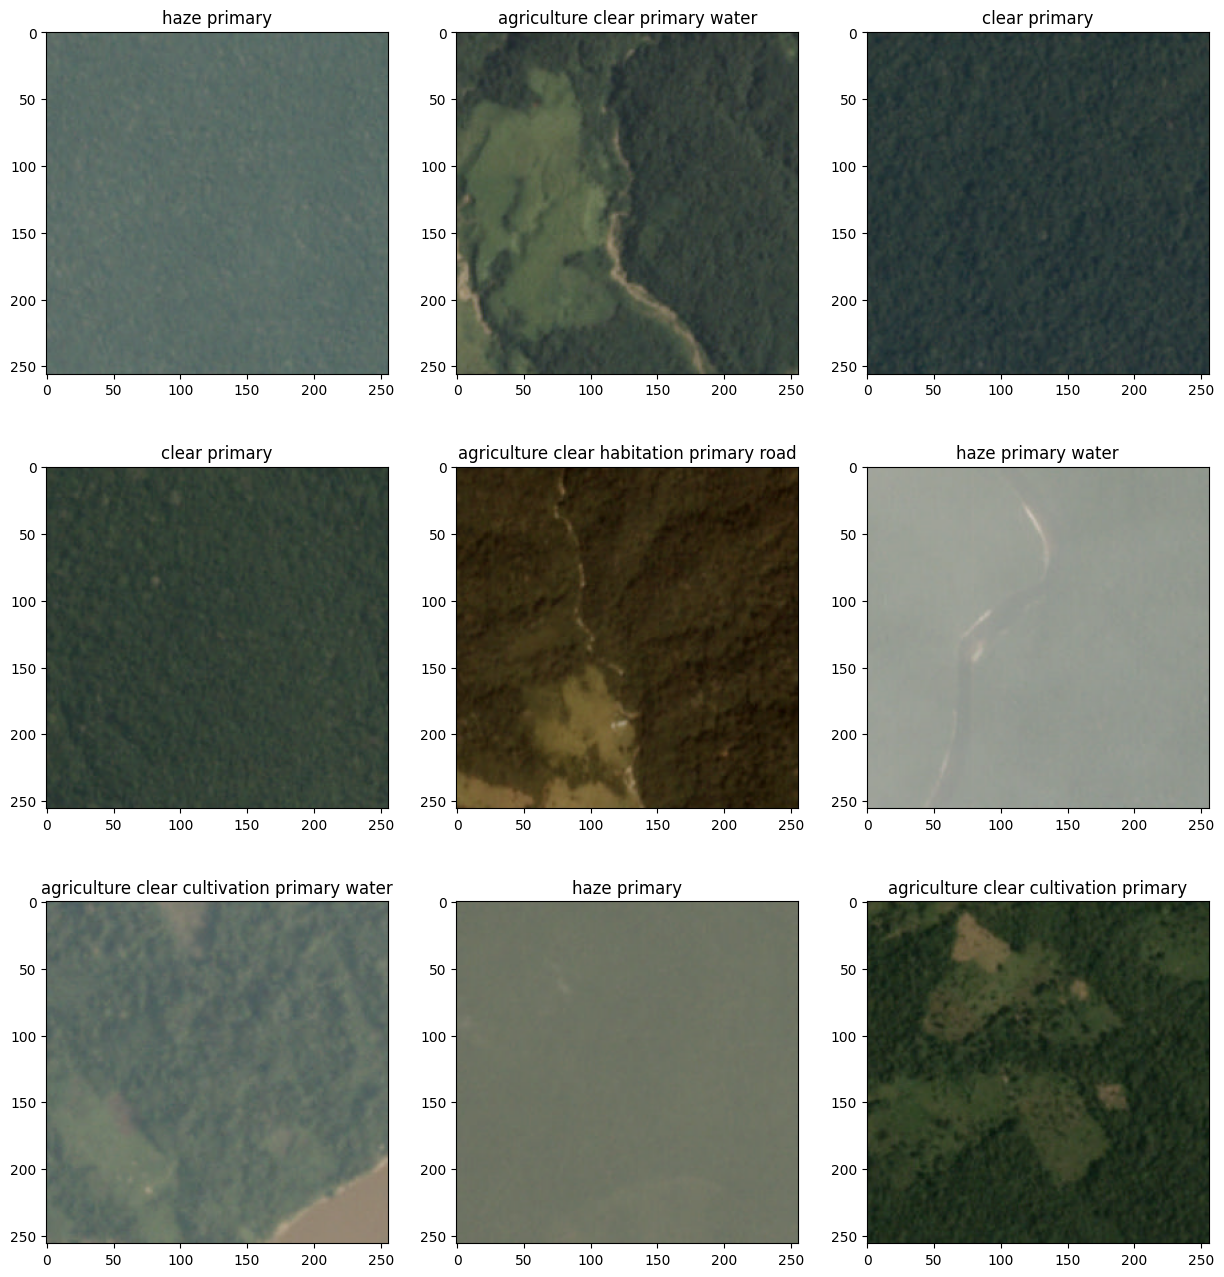

In [11]:
#Visualising training images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Create a figure and axes object
fig, axs = plt.subplots(3, 3, figsize=(15, 16))

for i in range(9):
    filename = "planet/train-jpg/"+ 'train_' + str(i) + '.jpg'
    img = mpimg.imread(filename)
    # Get the row and column indices of the current image
    row, col = divmod(i, 3)
    label = classes.loc[classes['image_name'] == 'train_' + str(i), 'tags'].iloc[0]

    # Plot the image in the corresponding subplot
    axs[row, col].imshow(img)
    axs[row, col].set_title(label)
    

In [12]:
# Add onehot features for every label in the list
classes_one_hot = pd.DataFrame()
for label in labels:
    classes_one_hot[label] = classes['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)

In [13]:
classes_one_hot.head()

,selective_logging,agriculture,cultivation,blooming,haze,bare_ground,cloudy,clear,partly_cloudy,blow_down,primary,road,habitation,conventional_mine,artisinal_mine,water,slash_burn
0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0


We can see that labels are highly unbalanced.

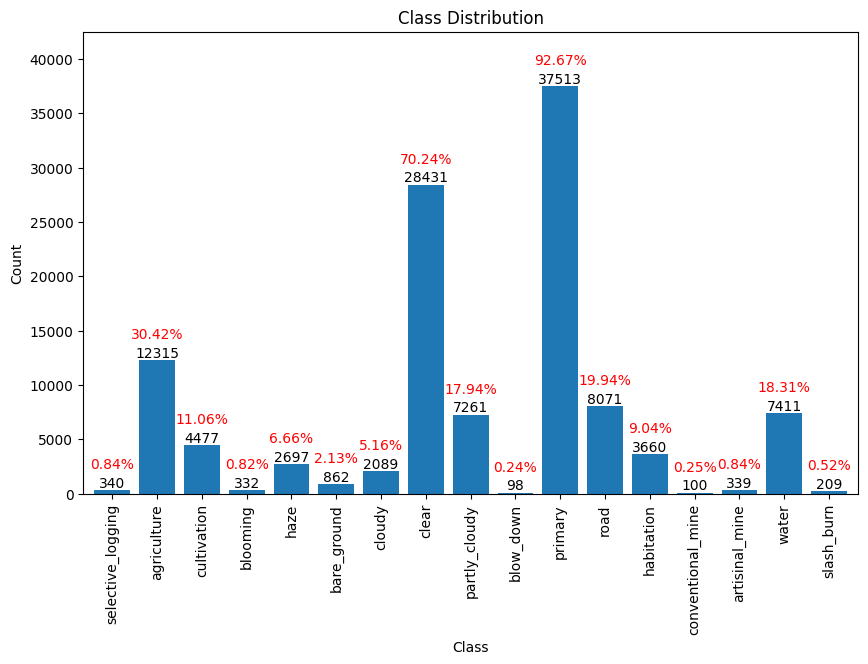

In [14]:
# looking at class distribution
sums = classes_one_hot.select_dtypes(np.number).sum().rename('count')
total_count = len(classes_one_hot)
percentages = (sums / total_count) * 100

# Create bar plot with annotations
fig, ax = plt.subplots(figsize=(10, 6))
sums.plot.bar(ax=ax, width=0.8)
for i, val in enumerate(sums.values):
    ax.annotate(int(val), (i, val), ha='center', va='bottom', fontsize=10)
    ax.annotate(f"{percentages[i]:.2f}%", (i, val + 2000), ha='center', fontsize=10, color='red')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.ylim(0, max(sums.values) + 5000)
plt.show()


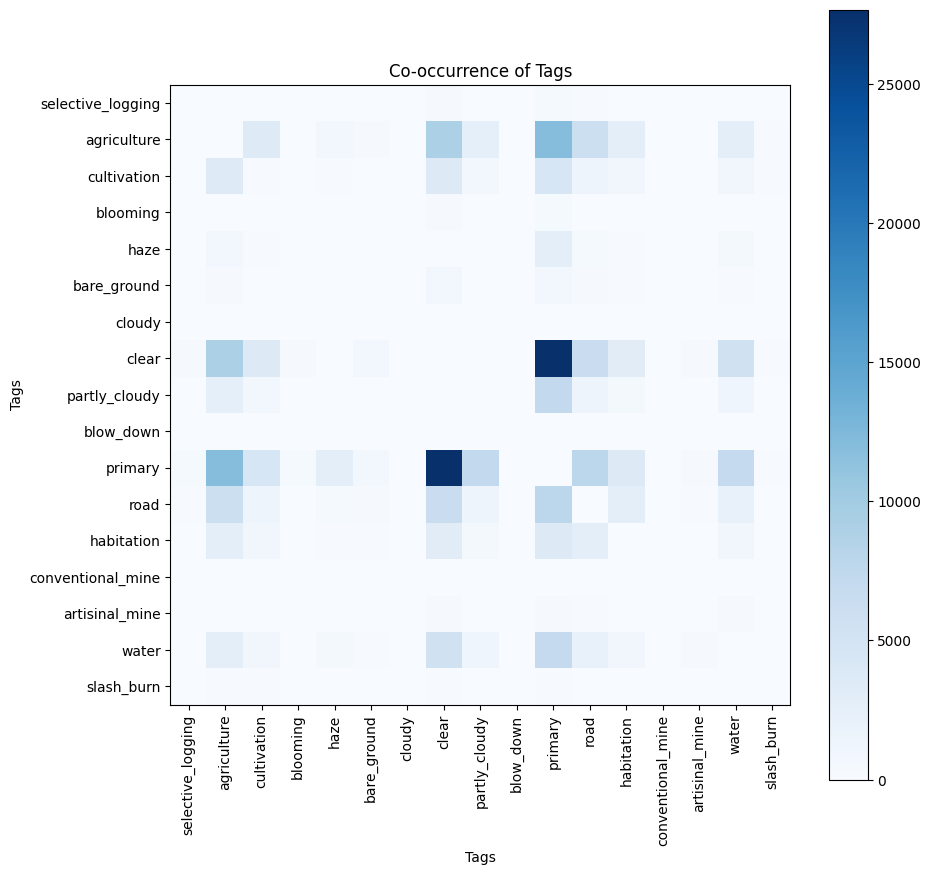

In [16]:
# plotting co occurance of tags
from itertools import combinations
tag_to_idx = {tag: i for i, tag in enumerate(labels)}

# Create a co-occurrence matrix
cooc_mat = np.zeros((len(labels), len(labels)), dtype=int)
for row in classes['tags']:
    tag_list = row.split()
    for i, j in combinations(tag_list, 2):
        cooc_mat[tag_to_idx[i], tag_to_idx[j]] += 1
        cooc_mat[tag_to_idx[j], tag_to_idx[i]] += 1

# Plot the co-occurrence matrix as a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cooc_mat, cmap='Blues')

# Set tick labels
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.title('Co-occurrence of Tags')
plt.xlabel('Tags')
plt.ylabel('Tags')
plt.show()


In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.applications import VGG16

2023-04-21 15:48:34.193505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 15:48:34.957351: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [18]:
from tensorflow.keras.utils import load_img,img_to_array
img_height = 128
img_width = 128
x = []
# for i in tqdm(range(classes.shape[0])):
for i in tqdm(range(10000)):
    filename = "planet/train-jpg/"+ 'train_' + str(i) + '.jpg'
    img = load_img(filename,target_size=(img_width,img_height))
    img = img_to_array(img)
    x.append(img)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 920.95it/s]


In [19]:
X = np.array(x)

In [20]:
X.shape

(10000, 128, 128, 3)

In [21]:
type(X)

numpy.ndarray

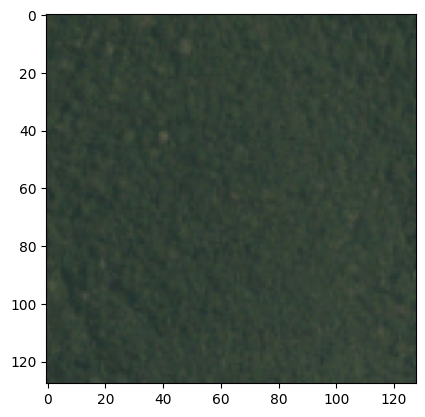

In [22]:
plt.imshow(X[3]/255.0)

In [23]:
# y = classes_one_hot.to_numpy()
y = classes_one_hot[0:10000].to_numpy()

In [24]:
y.shape

(10000, 17)

In [25]:
def define_model(dropout, adam_opt, in_shape=(128, 128, 3), out_shape=17):
    
    # Initiate model as sequential - will be a linear stack of layers
    model = Sequential()
    
    # Add first block
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPool2D((2, 2)))
    
    # dropout if set
    if dropout == True:
        model.add(Dropout(0.2))
    
    # Add second block
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPool2D((2, 2)))

    # dropout if set
    if dropout == True:
        model.add(Dropout(0.2))
    
    # Add third block
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPool2D((2, 2)))
    
    # dropout if set
    if dropout == True:
        model.add(Dropout(0.2))
    
    # Flatten (to 1D vector) and feed to fully connected layer (relu activation)
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    
    # dropout if set
    if dropout == True:
        model.add(Dropout(0.5))
    
    # feed to output layer (sigmoid)
    model.add(Dense(out_shape, activation='sigmoid'))
    
    # Initiate optimization
    if adam_opt == True:
        opt = Adam()
    else:
        opt = SGD(learning_rate=0.01, momentum=0.9)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
    
    return model

In [26]:
def model_vgg16(dropout, adam_opt, in_shape=(128, 128, 3), out_shape=17):

    # Load the VGG16 model without the top layer
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=in_shape)

    # Freeze all layers in the VGG16 model
    for layer in vgg16.layers:
        layer.trainable = False

    # Define the model architecture
    model = Sequential()
    model.add(vgg16)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    # dropout if set
    if dropout == True:
        model.add(Dropout(0.5))
    model.add(Dense(out_shape, activation='sigmoid'))
    
    if adam_opt == True:
        opt = Adam()
    else:
        opt = SGD(learning_rate=0.01, momentum=0.9)

    # Compile the model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[weighted_fbeta])
    
    return model

In [27]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

In [28]:
def run_test(x,y,
             in_shape,
             epochs,
             dropout=False,
             augment=False,
             adam_opt=False,
             transfer=False):
    
     
    # load dataset
    X_train, X_test, y_train, y_test = train_test_split(x,y,random_state=42,test_size=0.30)
    
    # create data generator(s)
    if augment == True:
        train_datagen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, vertical_flip=True, rotation_range=90)
        test_datagen = ImageDataGenerator(rescale=1.0/255.0)
        
         # prepare iterators
        train_it = train_datagen.flow(X_train, y_train, batch_size=128)
        test_it = test_datagen.flow(X_test, y_test, batch_size=128)
        
        if transfer == False:
        
            model = define_model(dropout=dropout, adam_opt=adam_opt, in_shape=in_shape, out_shape=17)
            model.summary()
            
        else:
            model = model_vgg16(dropout=dropout, adam_opt=adam_opt, in_shape=in_shape, out_shape=17)
            model.summary()
    else:
        # no augmentation
        datagen = ImageDataGenerator(rescale=1.0/255.0)
        
        # prepare iterators
        train_it = datagen.flow(X_train, y_train, batch_size=128)
        test_it = datagen.flow(X_test, y_test, batch_size=128)
        
        if transfer == False:
        
            model = define_model(dropout=dropout, adam_opt=adam_opt, in_shape=in_shape, out_shape=17)
            model.summary()
            
        else:
            model = model_vgg16(dropout=dropout, adam_opt=adam_opt, in_shape=in_shape, out_shape=17)
            model.summary()

     
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
            validation_data=test_it, validation_steps=len(test_it), epochs=epochs, verbose=1)
    
    return  model, history

In [29]:
from keras import backend
def weighted_fbeta(y_true, y_pred, beta=2):
    # Ensure y_true and y_pred are of type float32 to support TPU training
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # clip predictions
    y_pred = backend.clip(y_pred, 0, 1)
    # calculate elements
    true_positive = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
    false_positive = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
    false_negative = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
    # calculate precision
    precession = true_positive / (true_positive + false_positive + backend.epsilon())
    # calculate recall
    recall = true_positive / (true_positive + false_negative + backend.epsilon())
    # calculate fbeta, averaged across each class
    beta_squared = beta ** 2
    fbeta_score = backend.mean((1 + beta_squared) * (precession * recall) / (beta_squared * precession + recall + backend.epsilon()))
    return fbeta_score

In [30]:
model, history = run_test(X,y,in_shape=(128,128,3),epochs=10,dropout=True,augment=True,adam_opt=False,transfer=True)

2023-04-21 15:49:06.689049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37858 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB MIG 3g.40gb, pci bus id: 0000:85:00.0, compute capability: 8.0


58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 17)                8721      
                                                                 
Total params: 18,918,225
Trainable params: 4,203,537
Non-trainable params: 14,714,688
_____________________________________

2023-04-21 15:49:10.222759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-21 15:49:13.913291: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:417] Loaded runtime CuDNN library: 8.5.0 but source was compiled with: 8.6.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2023-04-21 15:49:13.914817: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops_fused_impl.h:625 : UNIMPLEMENTED: DNN library is not found.
2023-04-21 15:49:13.914858: I tensorflow/core/common_runtime/ex

UnimplementedError: Graph execution error:

Detected at node 'sequential/vgg16/block1_conv1/Relu' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/xsingh1/.local/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/xsingh1/.local/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/xsingh1/.local/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/xsingh1/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/xsingh1/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/xsingh1/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/xsingh1/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/xsingh1/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/xsingh1/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/xsingh1/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1426219/4070760329.py", line 1, in <module>
      model, history = run_test(X,y,in_shape=(128,128,3),epochs=10,dropout=True,augment=True,adam_opt=False,transfer=True)
    File "/tmp/ipykernel_1426219/4055217429.py", line 49, in run_test
      history = model.fit(train_it, steps_per_epoch=len(train_it),
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/activations.py", line 317, in relu
      return backend.relu(
    File "/home/xsingh1/.local/lib/python3.8/site-packages/keras/backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential/vgg16/block1_conv1/Relu'
DNN library is not found.
	 [[{{node sequential/vgg16/block1_conv1/Relu}}]] [Op:__inference_train_function_1659]

In [32]:
def plot_learning_curve(history, epoch):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation accuracy values
    epoch_range = range(1, epoch+1)
    ax1.plot(epoch_range, history.history['weighted_fbeta'])
    ax1.plot(epoch_range, history.history['val_weighted_fbeta'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='upper left')

    # Plot training and validation loss
    ax2.plot(epoch_range, history.history['loss'])
    ax2.plot(epoch_range, history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper left')

    plt.show()

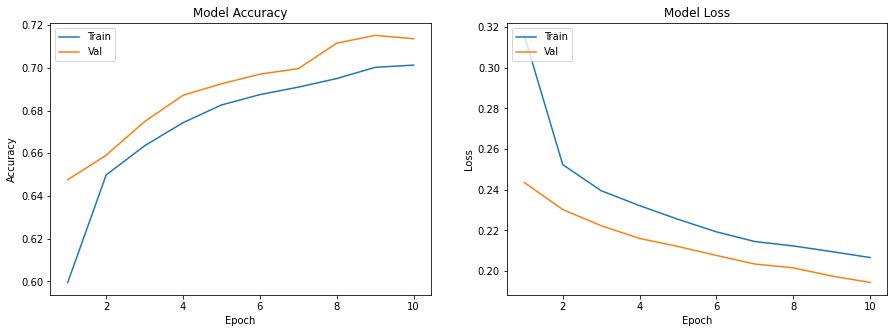

In [34]:
plot_learning_curve(history,10)

In [ ]:
img_path = 'planet/train-jpg/train_2005.jpg'
img = load_img(img_path, target_size=(128, 128))
# plt.imshow(img)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

# Get the model's prediction
prediction = model.predict(img_array)

#getting labels
Labels_pred = classes_one_hot.columns

# get indices of elements greater than 0.5
indices = np.where(prediction > 0.5)

# get corresponding labels
selected_labels = [Labels_pred[i] for i in indices[1]]

# print selected labels
print(selected_labels)

In [46]:
# function for getting prediction

def predict_labels(img_path, model):
    # Load and preprocess image
    img = load_img(img_path, target_size=(128, 128))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Get the model's prediction
    prediction = model.predict(img_array)

    # Get labels for predictions greater than 0.5
    labels = classes_one_hot.columns
    indices = np.where(prediction > 0.4)
    selected_labels = [labels[i] for i in indices[1]]

    return selected_labels

In [47]:
# Passing images for prediction
results = []
for i in range(40000,40011):
    img_path = "planet/train-jpg/"+ 'train_' + str(i) + '.jpg'
    img_name = 'train_' + str(i)
    labels = predict_labels(img_path, model)
    results.append({"image_name": img_name, "tags": labels})
tmp = pd.DataFrame(results)

1/1 [==============================] - 0s 75ms/step


In [48]:
tmp

,image_name,tags
0,train_40000,"[clear, primary]"
1,train_40001,"[clear, primary]"
2,train_40002,"[clear, road, water, agriculture, primary]"
3,train_40003,"[clear, primary]"
4,train_40004,"[partly_cloudy, agriculture, primary]"
5,train_40005,"[clear, road, agriculture, primary]"
6,train_40006,"[clear, primary]"
7,train_40007,"[partly_cloudy, agriculture, primary]"
8,train_40008,"[clear, partly_cloudy, agriculture, primary]"
9,train_40009,"[clear, agriculture, primary]"


In [45]:
classes[40000:40011]

,image_name,tags
40000,train_40000,agriculture clear
40001,train_40001,clear primary
40002,train_40002,agriculture clear primary road water
40003,train_40003,clear primary
40004,train_40004,agriculture partly_cloudy primary road
40005,train_40005,agriculture clear habitation primary road
40006,train_40006,clear primary
40007,train_40007,partly_cloudy primary
40008,train_40008,cloudy
40009,train_40009,agriculture haze primary road water


In [53]:
label = classes.loc[classes['image_name'] == 'train_' + str(i), 'tags'].iloc[0]

In [54]:
label

'agriculture clear primary water'